In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers
from tensorflow import  keras
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split, cross_validate

In [19]:
data_path = "/content/drive/MyDrive/Colab Notebooks/NLP/Cafe_Bazar/Codes /data_labelled.csv"
data = pd.read_csv(data_path, index_col=0)
data.dropna(inplace=True)
print(data.shape)
data.head()

(3589, 4)


,text,label,comment_len,clean_text
id,,,,
131244574,عالی عالی عالی عالی عالی عالی عالی عالی عالی ع...,0,27,عالی عالی عالی عالی عالی عالی عالی عالی عالی ع...
133141894,دوستان این نظرات و پیشنهادات رو باید به پشتیبا...,0,24,دوستان نظرات پیشنهاد پشتیبان تیک اسنپ فرستاد#ف...
94129372,خیلی ایراد داره مسخره تر از این نمیشه رقیب‌هات...,1,25,ایراد مسخره نمیشه رقیبهات روح ماشین رد میشن ام...
131334220,نه کی گفته خرابه من دارم باهاش کار میکنم از من...,0,20,خرابه با کار رایگانه ممنون سازنده ستاره کمه
131387172,سلام عالیه حتما نصب کنید از کالاف دیوتی هم بهتره,0,10,سلام عالیه نصب کالاف دیوتی بهتره


In [20]:
X_train, X_test, y_train, y_test = train_test_split(data.clean_text.to_numpy(), data.label.to_numpy(), test_size = 0.2, random_state=42, stratify=data.label.to_numpy())

print(f'train data shape for semi_supervised learning : {X_train.shape}')
print(f'train label shape for semi_supervised learning : {y_train.shape}')

print(f'test data shape for semi_supervised learning : {X_test.shape}')
print(f'test label shape for semi_supervised learning : {y_test.shape}')

train data shape for semi_supervised learning : (2871,)
train label shape for semi_supervised learning : (2871,)
test data shape for semi_supervised learning : (718,)
test label shape for semi_supervised learning : (718,)


In [21]:
comment_tokens = Tokenizer( oov_token='OOV')
comment_tokens.fit_on_texts(X_train)
X_train = np.array(comment_tokens.texts_to_sequences(X_train), dtype=object)
X_test = np.array(comment_tokens.texts_to_sequences(X_test), dtype=object)

word_index = comment_tokens.word_index
vocab = np.array(list(word_index.keys()))
vocab_size = len(vocab)
print("Number fo Unique Tokens is : ", vocab_size)

Number fo Unique Tokens is :  6185


In [22]:
lengths=[]
for k in range(len(X_train)):
  lengths.append(len(X_train[k]))
pd.DataFrame(lengths, columns=['Lenghts']).describe()
     

,Lenghts
count,2871.000000
mean,8.820620
std,5.193759
min,1.000000
25%,5.000000
50%,8.000000
75%,12.000000
max,46.000000


train comments median lenght 8


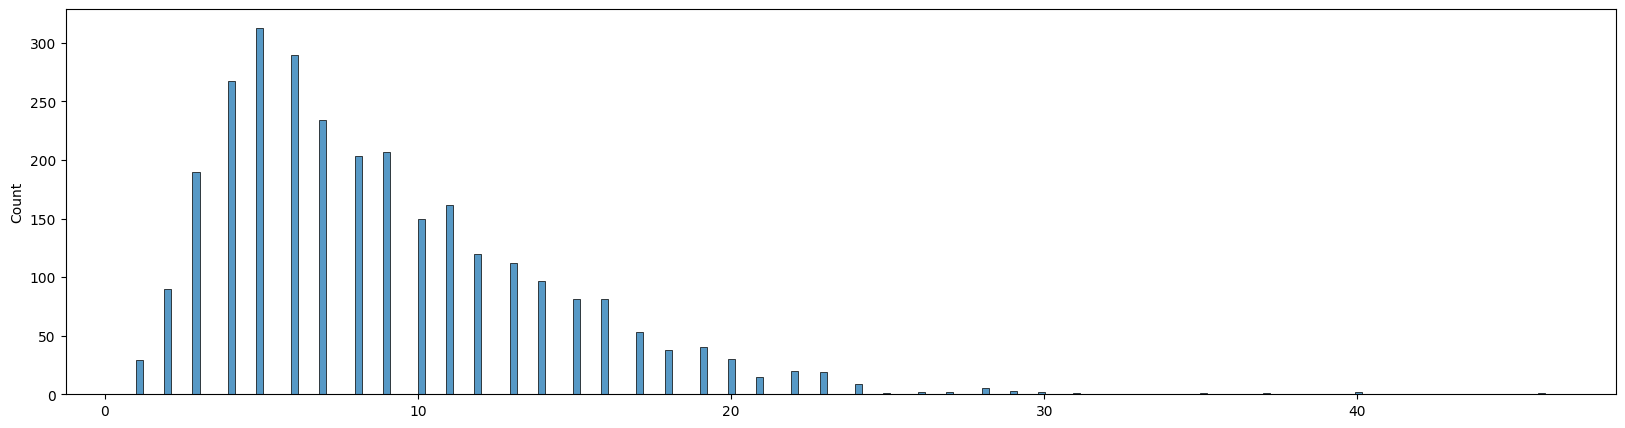

In [23]:


train_median_len = int(np.percentile(lengths, 50))
print(f'train comments median lenght {train_median_len}')
plt.figure(figsize=(20, 5))
_ = sns.histplot(lengths, bins=200)
     



In [24]:
max_length = train_median_len
trunc_type = 'post'
padding_type = 'post'
X_train = pad_sequences(X_train, maxlen=max_length, padding=padding_type, truncating=trunc_type)
X_test = pad_sequences(X_test, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [15]:
weights = compute_class_weight(class_weight = 'balanced', classes= np.unique(y_train), y= y_train.reshape(-1))

class_weights = {c : w for c, w in enumerate(weights)}
print(class_weights)

{0: 0.731651376146789, 1: 1.5792079207920793}


In [31]:
embed_size = 100
num_oov_buckets = 100
GRU_model = keras.models.Sequential([
    keras.layers.Embedding(len(vocab) + num_oov_buckets, embed_size,
    input_shape=[train_median_len]),
    keras.layers.LSTM(4, dropout=.5),
    keras.layers.Dense(1, activation="sigmoid")
])
GRU_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 8, 100)            628500    
                                                                 
 lstm_2 (LSTM)               (None, 4)                 1680      
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 630,185
Trainable params: 630,185
Non-trainable params: 0
_________________________________________________________________


In [32]:
callbacks = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss')
GRU_model.compile(loss='binary_crossentropy', 
                optimizer=keras.optimizers.Adam(learning_rate=5e-5),
                metrics=['accuracy', keras.metrics.AUC()]
                )
GRU_history = GRU_model.fit(X_train, y_train, epochs=100, verbose=1, batch_size = 32,
                    validation_split=0.1, callbacks = callbacks, class_weight=class_weights)
     


Epoch 1/100
81/81 [==============================] - 5s 25ms/step - loss: 0.6887 - accuracy: 0.6086 - auc_3: 0.5876 - val_loss: 0.6865 - val_accuracy: 0.6736 - val_auc_3: 0.6781
Epoch 2/100
81/81 [==============================] - 1s 16ms/step - loss: 0.6855 - accuracy: 0.6694 - auc_3: 0.6546 - val_loss: 0.6816 - val_accuracy: 0.7014 - val_auc_3: 0.6966
Epoch 3/100
81/81 [==============================] - 1s 16ms/step - loss: 0.6818 - accuracy: 0.7042 - auc_3: 0.6988 - val_loss: 0.6766 - val_accuracy: 0.7014 - val_auc_3: 0.7031
Epoch 4/100
81/81 [==============================] - 1s 16ms/step - loss: 0.6778 - accuracy: 0.7259 - auc_3: 0.7223 - val_loss: 0.6714 - val_accuracy: 0.7083 - val_auc_3: 0.7159
Epoch 5/100
81/81 [==============================] - 2s 20ms/step - loss: 0.6735 - accuracy: 0.7414 - auc_3: 0.7370 - val_loss: 0.6658 - val_accuracy: 0.7049 - val_auc_3: 0.7211
Epoch 6/100
81/81 [==============================] - 2s 22ms/step - loss: 0.6694 - accuracy: 0.7538 - auc_3: 0

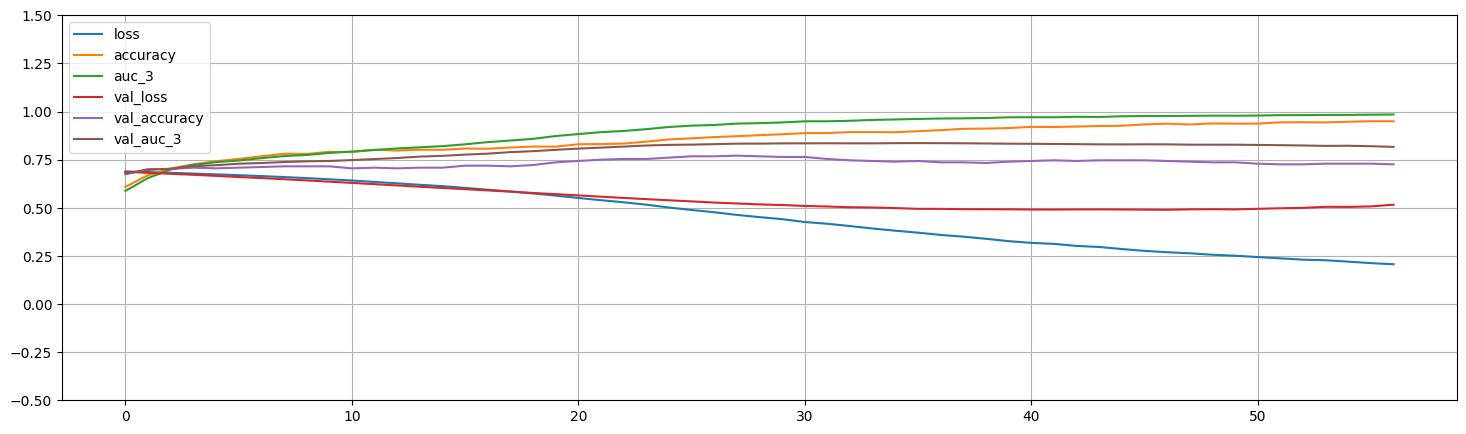

In [33]:
pd.DataFrame(GRU_history.history).plot(figsize=(18, 5))
plt.grid(True)
plt.gca().set_ylim(-0.5, 1.5) # set the vertical range to [0-1]
plt.show()

In [34]:
GRU_model.evaluate(X_test, y_test)

23/23 [==============================] - 1s 3ms/step - loss: 0.5429 - accuracy: 0.7145 - auc_3: 0.7783


[0.5428961515426636, 0.714484691619873, 0.7783315181732178]

In [36]:
gru_preds = GRU_model.predict(X_test)
predicted_label = [1 if proba >0.5 else 0 for proba in gru_preds]

23/23 [==============================] - 0s 3ms/step


In [ ]:
gru_preds

In [38]:
from sklearn.metrics import confusion_matrix, classification_report

              precision    recall  f1-score   support

           0       0.84      0.72      0.78       491
           1       0.54      0.70      0.61       227

    accuracy                           0.71       718
   macro avg       0.69      0.71      0.69       718
weighted avg       0.74      0.71      0.72       718



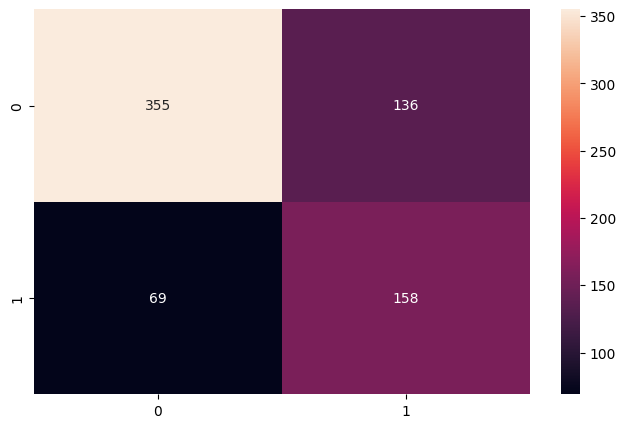

In [41]:
_ =  plt.figure(figsize=(8, 5))
_ = sns.heatmap(confusion_matrix(y_test, predicted_label), annot=True, fmt='g')
print(classification_report(y_test.reshape(-1),  predicted_label))